# A simple background elimination method for Raman spectra

In this notebook we are trying to reproduce the background elimination technique described in the article of Seong-Joon Baek, Aaron Park, Jinyoung Kim, Aigou Shen, Jiming Hu: https://doi.org/10.1016/j.chemolab.2009.04.007. In the following we report the abstract.

**Abstract**

In this paper, we consider a new background elimination method for Raman spectra. The proposed method is based on peak detection, smoothing, and interpolation. Since the background is usually slowly varying with respect to wavelength, we could estimate the background by eliminating significant peaks. For this purpose, we seek the peaks by inspecting the smoothed derivative of a given spectrum. After clipping out the corresponding peak regions, we estimate the background by applying a modified linear interpolation. Then the background is eliminated from the measured Raman spectrum by simple subtraction. The experimental results showed that the proposed method gave satisfactory results for real Raman spectra as well as synthetic data. As the proposed method requires no prior knowledge of spectrum, we expect that the method could be applied to other spectral data as well.

### Settings and functions

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
%matplotlib inline
font = {'size': 15}

ModuleNotFoundError: No module named 'pandas'

In [3]:
def raman_plot():
    """
    Funzione che serve per settare la dimensione dell'immgine e i label degli assi per un plot di spettro Raman.
    """
    plt.figure(figsize=(16,6))
    plt.xlabel(r"wave number [$cm^-1$]",fontsize=18)
    plt.ylabel("Intensity [some unit]",fontsize=18)

In [4]:
def define_names(r=11,c=11):
    """
    Funzione che definisce i nomi delle coordinate degli spettri sul sample. I nomi sono del tipo r1c1,r1c2, ecc.
    Come default usa 11 colonne e 11 righe. Il primo nome è wn, che sta per wave number.
    """
    #definisco i nomi da assegnare ai punti delli spettri di sampling
    #wn -> wave number  r -> row c -> columns
    names = ['wn']+[f'r{k}c{i}' for k in range(1,r+1) for i in range(1,c+1)]
    return names

In [5]:
def moving_average_filter(a,L):
    """
    A simple (non causal) moving average filter with span L with particular boundary conditions.
    """
    if L%2==0:
        print('Error, L must be eaven')
    else:
        a=np.convolve(np.array(a),np.ones(L))
        a=np.delete(a,list(range(len(a)-(L-1)//2, len(a))))
        a=np.delete(a,list(range((L-1)//2)))
        for i in range(len(a)):
            if (L//2+1+i)<L:
                a[i]=a[i]/(L//2+1+i)
            elif L//2+(len(a)-i)<L:
                a[i]=a[i]/(L//2+(len(a)-i))
            else:
                a[i]=a[i]/L
    return a

## Import of some test spectra
Here we import a few spectra on which to test this background-elimination technique. Then we chose one among these in the variable *col* on which the procedure is performed, change that variable to change the "test-spectrum".

In [6]:
#definisco i nomi delle colonne da dare 
names=define_names()

#qui importiamo i dati dei sampling in dataframes pandas, la colonna dei numeri d'onda è una unica per tutti
data = pd.read_csv('./data/S1_mapA_11x11.txt', delim_whitespace=True, names=names)
data_bkg = pd.read_csv('./data/S1_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)

# The procedure
Here is the spectrum on wich we develop the background elimination presented in the article.

Text(0.5, 1.0, 'Spectrum on which to test the analisis')

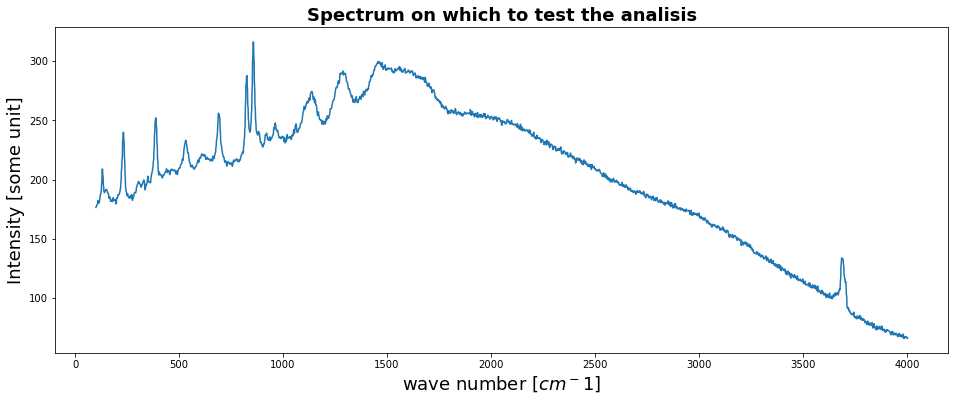

In [7]:
col='r5c5'
signal=data[['wn',col]].copy().rename(columns={col:'signal'})
raman_plot()
plt.plot(signal.wn,signal.signal)
plt.title('Spectrum on which to test the analisis',fontsize=18,fontweight='bold')

## Noise removal
Apply Savitzky–Golay ﬁlter with span $L_n$ to the given spectrum. The degree of a polynomial is set to 2. Alternatively, simple averaging ﬁlter can be used for practical reason. In the following, $s$ denotes the
noise removed data.

In [38]:
###########################################################################################
L_n=25                                     #lenght of smoothing filter for noise removal#
###########################################################################################

s=savgol_filter(signal.signal,L_n,2)

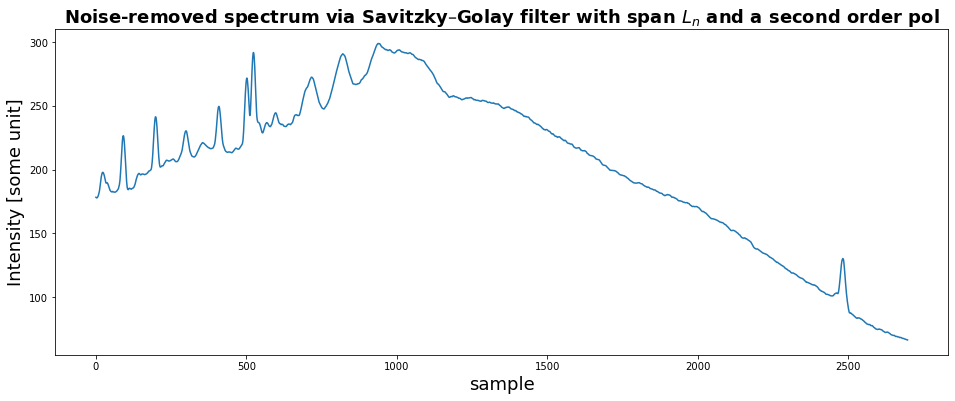

In [39]:
plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("Intensity [some unit]",fontsize=18)
plt.title('Noise-removed spectrum via Savitzky–Golay filter with span $L_n$ and a second order pol',fontsize=18,fontweight='bold')
plt.plot(s)

## Finding derivatives
As the noise removed data still suffer from the remaining noise, we apply smoothing to s with span $L_n$ before and after differentiation to make the derivative smoother.
$$ds=smooth(diff(smooth(s,L_n)),L_n)$$

Now the derivative of the background signal can be obtained by smoothing $ds$ three times with span $L_b$.

$$s3ds=smooth(smooth(smooth(ds,L_b),L_b),L_b)$$

Then the derivative of a given spectrum without background is simply estimated as $dg = ds − s3ds$.

In [40]:
ds=savgol_filter(np.diff(savgol_filter(s,L_n,2)),L_n,2) #smoothing with savgol filter
#ds=moving_average_filter(np.diff(moving_average_filter(s,L_n)),L_n) #or with a rolling average
#the difference is a vector with one dimension less!!!

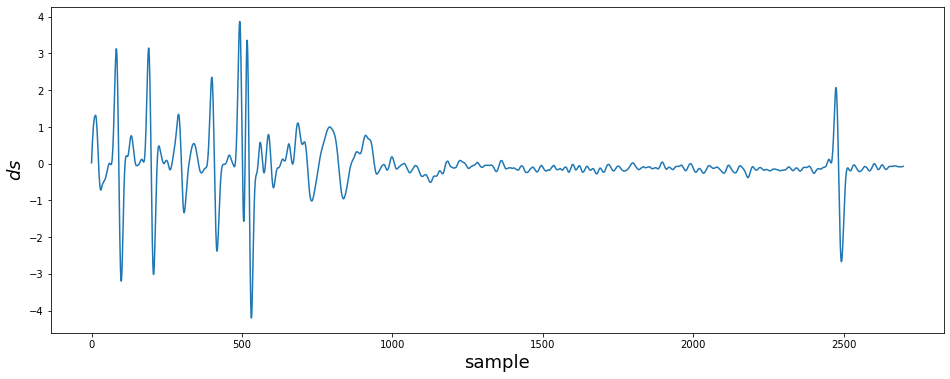

In [41]:
plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("$ds$",fontsize=18)
plt.plot(ds)

Now the derivative of the background signal can be obtained by smoothing ds three times with span $L_b$.

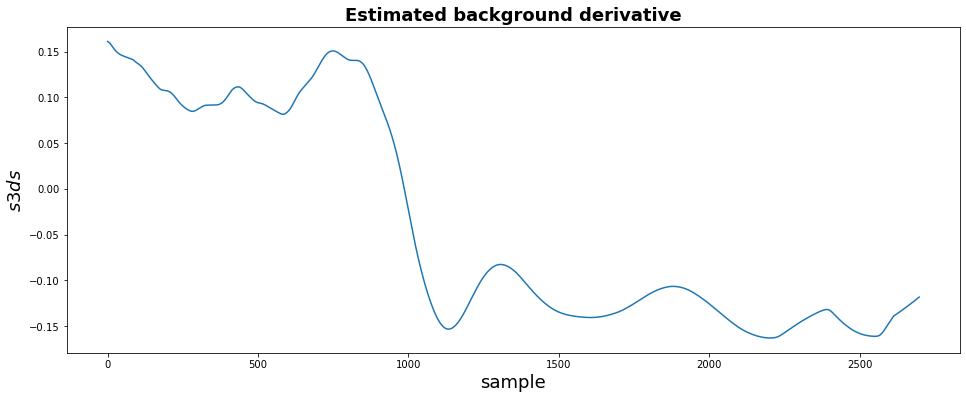

In [52]:
#######################################################################################
L_b=171                 #lenght of smoothing filter "derivative of peaks removement#
#######################################################################################

s3ds=moving_average_filter(moving_average_filter(moving_average_filter(ds,L_b),L_b),L_b)

plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("$s3ds$",fontsize=18)
plt.title('Estimated background derivative',fontsize=18,fontweight='bold')

plt.plot(s3ds)

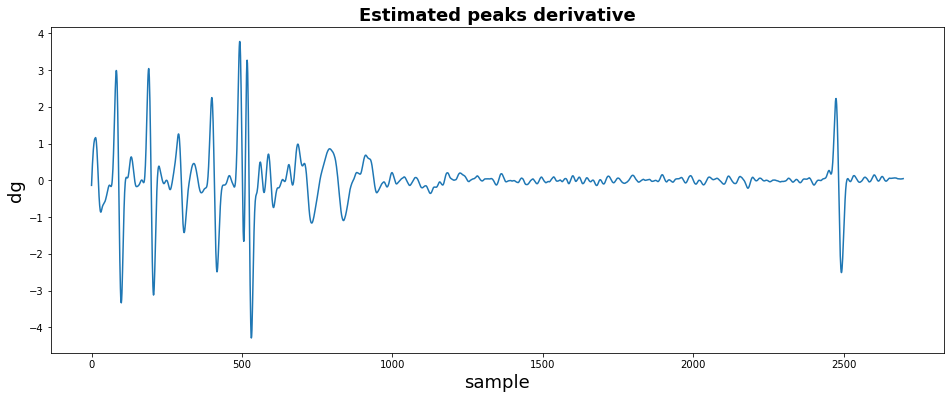

In [53]:
dg=ds-s3ds
plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("dg",fontsize=18)
plt.title('Estimated peaks derivative',fontsize=18,fontweight='bold')
plt.plot(dg)

## Peak detection
Find peak positions first where the sign of dg changes from + to −. Let the peak position be $p_k$, $k = 1,2,⋯,m$, where $m$ is the number of peaks found. For a given $p_k$, left and right boundary can be found in the following way. Let $i$ decrease from $p_k$. Find the position where $dg(i − 1)< dg(i)$ for local maximum. From there, proceed to ﬁnd the position where $dg(i − 1)> dg(i)$ or $dg(i − 1)< threshold$. The position $i − 1$ is left boundary, $pl_k$ . Similarly for the right boundary. The threshold is set to 0.02 in the paper. Lastly we drop small peaks, with boundary closer than $2*L_n$, and we join close peaks (i.e with close boundaries) with a parameter $min\_ dist$.

### Find peak position

In [54]:
temp=[]
for i in range(1,len(dg)-1):
    if (dg[i-1]>0 and dg[i+1]<0) and dg[i-1]>dg[i] and dg[i]>dg[i+1]:
        temp.append(i)
peak=[]
for i in range(1,len(temp)):
    if temp[i]-temp[i-1]==1:
        peak.append(temp[i-1]) 

### Find boundaries of peaks

In [55]:
treshold=0.2

pl=[]
pr=[]
for k in peak:
    left_m=False
    right_m=False
    for i in range(k,k-len(s),-1):
        if (left_m==True and (dg[i]>dg[i+1] or abs(dg[i])<treshold)) or i==0:
            pl.append(i)
            break
        if dg[i]<dg[i+1] and left_m==False:
            left_m=True
    for i in range(k,k+len(s),+1):
        if (right_m==True and (dg[i]<dg[i-1] or abs(dg[i])<treshold)) or i==(len(dg)-1):
            pr.append(i)
            break
        if dg[i]>dg[i-1] and right_m==False:
            right_m=True
            

### Drop small peaks

In [56]:
L_max=L_n #because L_n is of the order of half of the smallest peak

temp=[]
for i in enumerate(np.array(pr)-np.array(pl)):
    if i[1]<L_max:
        temp.append(i[0])

In [57]:
peak=np.delete(np.array(peak),temp)
pl=np.delete(np.array(pl),temp)
pr=np.delete(np.array(pr),temp)

### Join close boundaries

In [58]:
min_dist=5
for i in range(len(peak)-1):
    if pl[i+1]-pr[i]<min_dist:
        pr[i]=pr[i+1]
        pl[i+1]=pl[i]

Text(0.5, 1.0, 'Estimated peaks derivative with detected peaks')

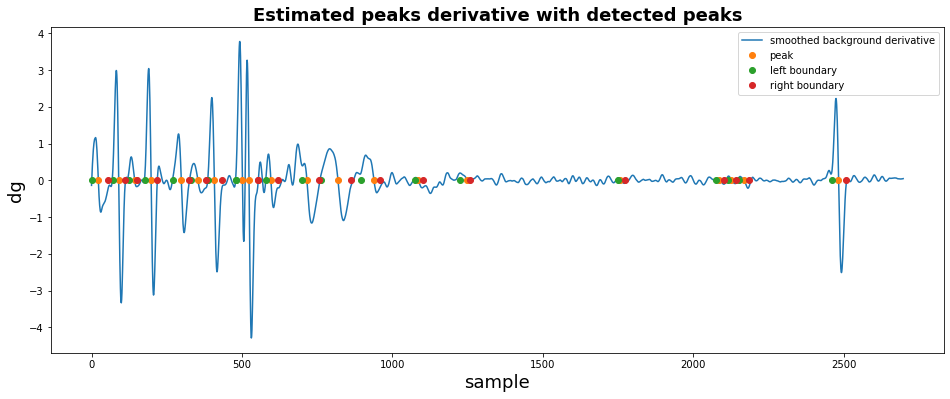

In [59]:
plt.figure(figsize=(16,6))
plt.plot(dg)
plt.plot(peak,np.zeros(len(peak)),marker='o',linewidth=0)
plt.plot(pl,np.zeros(len(peak)),marker='o',linewidth=0)
plt.plot(pr,np.zeros(len(peak)),marker='o',linewidth=0)
plt.legend(['smoothed background derivative','peak','left boundary','right boundary'])
plt.xlabel("sample",fontsize=18)
plt.ylabel("dg",fontsize=18)
plt.title('Estimated peaks derivative with detected peaks',fontsize=18,fontweight='bold')

**I have to figure out one last thing, about boundary adjustment**

## Interpolation
Interpolate every peak regions of s with a straight line. Let $lints_k$ be the linearly interpolated line and $s3ds_k$ be the parts of $s3ds$ in one peak region. Interpolated samples on that region, $bkg_k$, are obtained in
the following way.

$$diffline=s3ds_k-mean(srds_k)$$
$$bkg_k=lints_k+cumsum(diffline)$$
Now background estimate, bkg, can be obtained by aggregating
interpolated samples of all peak regions together with untouched
parts of s. Then smoothed background, sbkg, is obtained as $sbkg = smooth(bkg, L_b )$.

In [60]:
bkg=s.copy()
for i in range(len(peak)):
    diffline=s3ds[pl[i]:pr[i]]-s3ds[pl[i]:pr[i]].mean()
    m=(s[pl[i]]-s[pr[i]])/(pl[i]-pr[i])
    q=(s[pr[i]]*pl[i]-s[pl[i]]*pr[i])/(pl[i]-pr[i])
    bkg[pl[i]:pr[i]]=m*np.array(range(pl[i],pr[i]))+q+np.cumsum(diffline)
sbkg=moving_average_filter(moving_average_filter(bkg,L_b),L_b)

Text(0, 0.5, 'Intensity [some unit]')

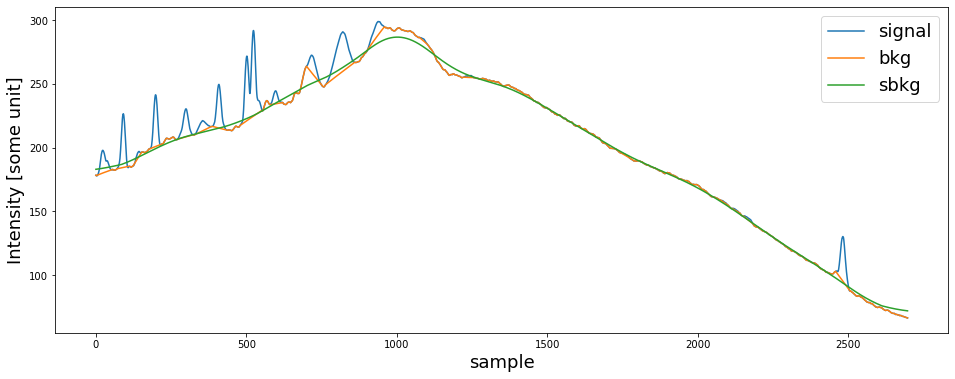

In [61]:
plt.figure(figsize=(16,6))
plt.plot(s)
plt.plot(bkg)
plt.plot(sbkg)
plt.legend(['signal','bkg','sbkg'],fontsize=18)
plt.xlabel("sample",fontsize=18)
plt.ylabel("Intensity [some unit]",fontsize=18)


# Background elimination
The spectrum without background can be estimated with simple subtraction as $x = s − b$. 

In case x contains some negative values, ﬁx it by adding a constant or forcing them to zero. In our experiments, a
constant adding method is adopted.

In [62]:
x=s-sbkg

Text(0.5, 1.0, 'The background removed spectrum')

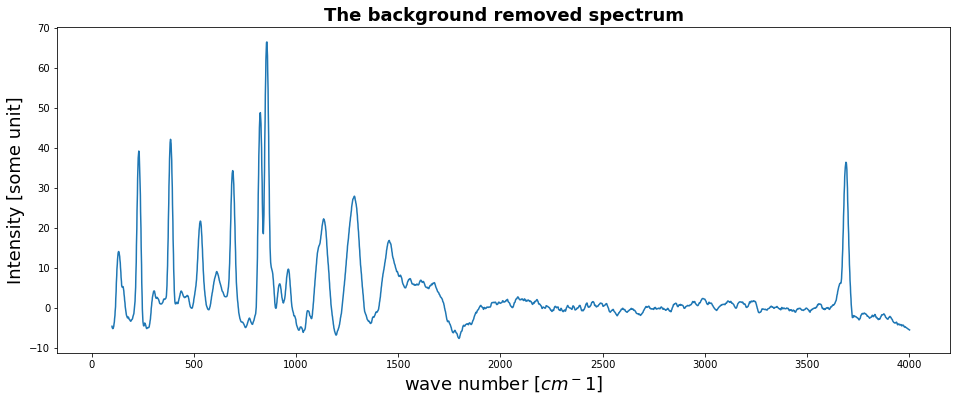

In [63]:
raman_plot()
plt.plot(signal.wn,x,31,5)
plt.title('The background removed spectrum',fontsize=18,fontweight='bold')

**Comparison with professor algorithm**

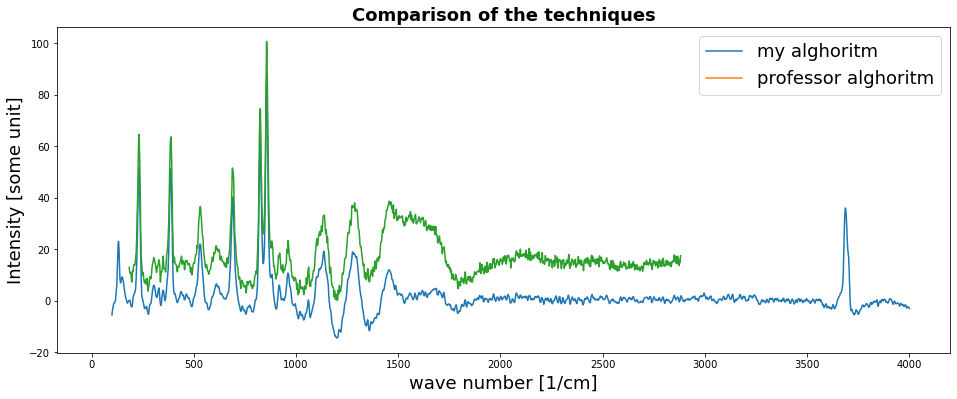

In [353]:
raman_plot()
plt.plot(signal.wn,x,31,5)
plt.plot(data_bkg.wn,data_bkg[col],31,5)
plt.title('Comparison of the techniques',fontsize=18,fontweight='bold')

plt.legend(['my alghoritm','professor alghoritm'], fontsize=18)